<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/MDP_gamma_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def value_iteration(gamma, epsilon=0.001):
    """
    Performs value iteration on the grid world.

    Grid layout (0-indexed):
      Columns: 0,1,2,3
      Rows: 0,1,2   (row 0 is bottom)

    Special cells:
      - Terminal states:
            (3,2) with reward +1   (top-right)
            (3,1) with reward -1   (middle-right)
      - Blocked cell (inaccessible):
            (1,1)
      - All other states get a reward of -0.04 per move.

    Actions:
      - 'up', 'down', 'left', 'right'
      - When an action is chosen, the agent moves in the intended direction with probability 0.8,
        and in each of the two perpendicular directions with probability 0.1.
      - If a move would hit the wall, go off the grid, or hit the blocked cell, the agent remains in place.

    Returns:
      A tuple (U, terminals) where U is a dictionary mapping each accessible state (tuple (x,y))
      to its computed utility and terminals is the dictionary of terminal states.
    """
    # Grid dimensions
    width, height = 4, 3

    # Define the blocked cell and terminal states
    wall = (1, 1)  # blocked cell (inaccessible)
    terminals = {(3, 2): 1, (3, 1): -1}

    # Build list of states (all grid cells except the wall)
    states = [(x, y) for x in range(width) for y in range(height) if (x, y) != wall]

    # Set rewards: terminal states have their fixed rewards; all others get -0.04.
    rewards = {s: terminals[s] if s in terminals else -0.04 for s in states}

    # Define possible actions and their corresponding movement vectors.
    actions = ['up', 'down', 'left', 'right']
    action_vectors = {
        'up':    (0, 1),
        'down':  (0, -1),
        'left':  (-1, 0),
        'right': (1, 0)
    }
    # Perpendicular moves for each action.
    perpendicular = {
        'up':    ['left', 'right'],
        'down':  ['left', 'right'],
        'left':  ['up', 'down'],
        'right': ['up', 'down']
    }

    def move(state, vector):
        """Returns the resulting state when moving from 'state' using 'vector'.
           If the move goes off the grid or into the wall, the state remains unchanged."""
        next_state = (state[0] + vector[0], state[1] + vector[1])
        if (next_state[0] < 0 or next_state[0] >= width or
            next_state[1] < 0 or next_state[1] >= height or
            next_state == wall):
            return state
        return next_state

    # Initialize utilities: nonterminal states start at 0; terminal states fixed.
    U = {s: 0 for s in states}
    for s in terminals:
        U[s] = terminals[s]

    # Special-case: if gamma == 0, one iteration is enough because future rewards are ignored.
    if gamma == 0:
        for s in states:
            if s not in terminals:
                U[s] = rewards[s]
        # print("Gamma = 0, converged in one iteration.")
        return U, terminals

    iteration = 0
    while True:
        U_new = U.copy()
        delta = 0
        for s in states:
            if s in terminals:
                continue  # terminal states remain fixed
            action_values = []
            for a in actions:
                intended_state = move(s, action_vectors[a])
                perp1_state = move(s, action_vectors[perpendicular[a][0]])
                perp2_state = move(s, action_vectors[perpendicular[a][1]])
                expected_util = (0.8 * U[intended_state] +
                                 0.1 * U[perp1_state] +
                                 0.1 * U[perp2_state])
                action_values.append(expected_util)
            best_action_value = max(action_values)
            U_new[s] = rewards[s] + gamma * best_action_value
            delta = max(delta, abs(U_new[s] - U[s]))
        U = U_new
        iteration += 1
        # Convergence criterion adjusted for gamma
        if delta < epsilon * (1 - gamma) / gamma:
            break
    # print(f"Gamma = {gamma} converged after {iteration} iterations.")
    return U, terminals

def print_grid(U):
    """
    Prints the utility values in a grid format.
    Uses the same grid conventions as in value_iteration.
    """
    width, height = 4, 3
    wall = (1, 1)
    grid = []
    for y in reversed(range(height)):  # top row first
        row = []
        for x in range(width):
            s = (x, y)
            if s == wall:
                row.append(" WALL ")
            elif s in U:
                row.append(f"{U[s]:6.3f}")
            else:
                row.append("  N/A ")
        grid.append(row)
    for row in grid:
        print("\t".join(row))

def vectorize_utilities(U, terminals, width=4, height=3, wall=(1,1)):
    """
    Extracts the utilities of the 9 nonterminal states into a vector.

    The vector is built in row-major order (from bottom row upward, left to right),
    skipping the wall and terminal states.

    Returns:
      A list of 9 utility values.
    """
    vector = []
    for y in range(height):
        for x in range(width):
            s = (x, y)
            if s == wall or s in terminals:
                continue
            vector.append(U[s])
    return vector

# Loop over gamma values from 0 to 0.95 in steps of 0.05,
# compute the utility vector for each, and store into a matrix.
gammas = np.arange(0, 1.0, 0.05)  # will include 0.0 up to 0.95
matrix = []

for g in gammas:
    U, terminals = value_iteration(g, epsilon=0.001)
    vec = vectorize_utilities(U, terminals)
    matrix.append(vec)

matrix = np.array(matrix)



In [2]:
def print_grid(U):
    """
    Prints the utility values in a grid format.
    Uses the same grid conventions as in value_iteration.
    """
    width, height = 4, 3
    wall = (1, 1)
    grid = []
    for y in reversed(range(height)):  # top row first
        row = []
        for x in range(width):
            s = (x, y)
            if s == wall:
                row.append(" WALL ")
            elif s in U:
                row.append(f"{U[s]:6.3f}")
            else:
                row.append("  N/A ")
        grid.append(row)
    for row in grid:
        print("\t".join(row))
print_grid(U)

 0.647	 0.753	 0.855	 1.000
 0.557	 WALL 	 0.569	-1.000
 0.465	 0.386	 0.451	 0.230


In [3]:

def vectorize_utilities(U, terminals, width=4, height=3, wall=(1,1)):
    """
    Extracts the utilities of the 9 nonterminal states into a vector.

    The vector is built in row-major order (from bottom row upward, left to right),
    skipping the wall and terminal states.

    Returns:
      A list of 9 utility values.
    """
    vector = []
    for y in range(height):
        for x in range(width):
            s = (x, y)
            if s == wall or s in terminals:
                continue
            vector.append(U[s])
    return vector



In [4]:
dg=0.001

gammas = np.arange(0, 1.0, dg)
matrix = []

for g in gammas:
    U, terminals = value_iteration(g, epsilon=0.001)
    vec = vectorize_utilities(U, terminals)
    matrix.append(vec)

matrix = np.array(matrix)
# print("\nUtility matrix (each row corresponds to a gamma value):")
# print(matrix)


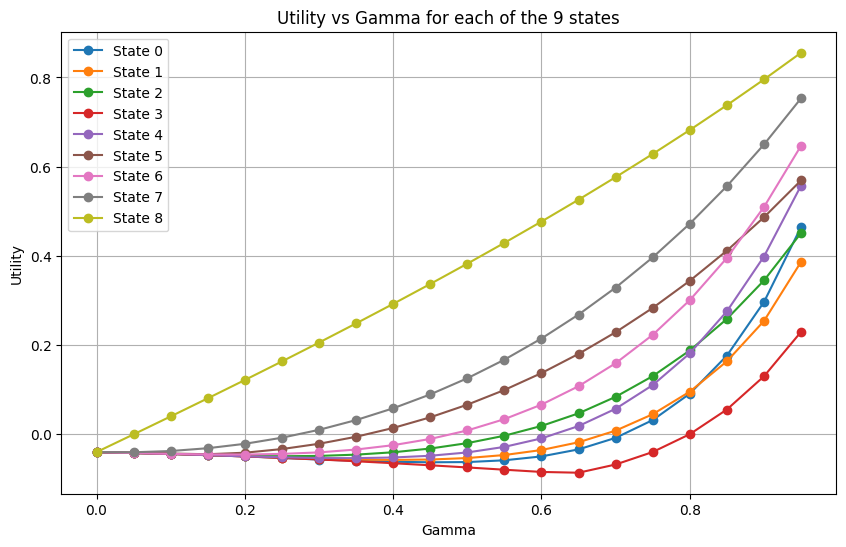

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the functions value_iteration, vectorize_utilities, etc. are defined as before.

# Compute the utility matrix for gamma values from 0 to 0.95 (step 0.05)
gammas = np.arange(0, 1.0, 0.05)  # gamma values: 0.0, 0.05, ..., 0.95
matrix = []

for g in gammas:
    U, terminals = value_iteration(g, epsilon=0.001)
    vec = vectorize_utilities(U, terminals)
    matrix.append(vec)

matrix = np.array(matrix)  # matrix shape: (num_gammas, 9)

# Plotting the utility for each of the 9 states as a function of gamma
plt.figure(figsize=(10, 6))
num_states = matrix.shape[1]

for state in range(num_states):
    plt.plot(gammas, matrix[:, state], marker='o', label=f'State {state}')

plt.xlabel("Gamma")
plt.ylabel("Utility")
plt.title("Utility vs Gamma for each of the 9 states")
plt.legend()
plt.grid(True)
plt.show()


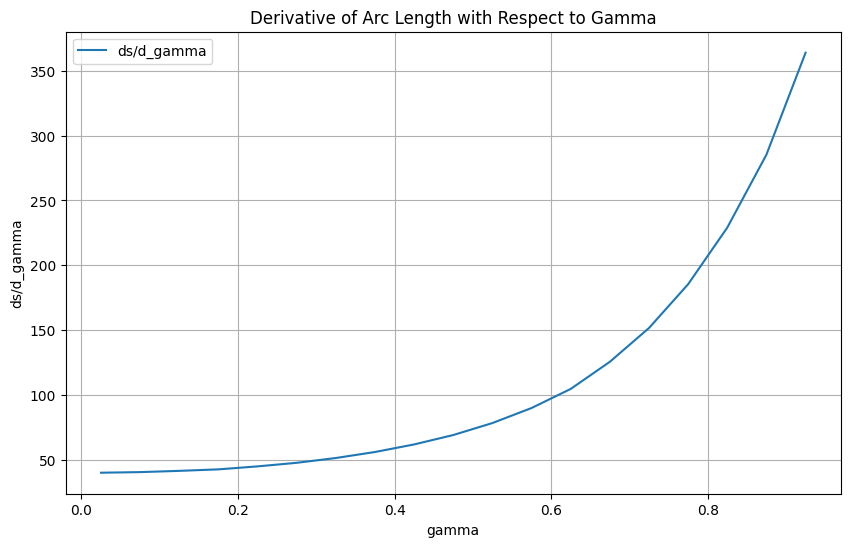

In [6]:

# Compute differences between successive points along the curve (axis=0)
diffs = np.diff(matrix, axis=0)

# Compute the Euclidean norm (l^2 norm) of these differences for each step
ds = np.linalg.norm(diffs, axis=1)

# Approximate ds/d_gamma (gamma step is constant: dg)
ds_dgamma = ds / dg

# For plotting, compute the midpoints of gamma values for each interval
gamma_mid = (gammas[:-1] + gammas[1:]) / 2

# Plot ds/d_gamma vs. gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_mid, ds_dgamma, label='ds/d_gamma')
plt.xlabel('gamma')
plt.ylabel('ds/d_gamma')
plt.title('Derivative of Arc Length with Respect to Gamma')
plt.legend()
plt.grid(True)
plt.show()


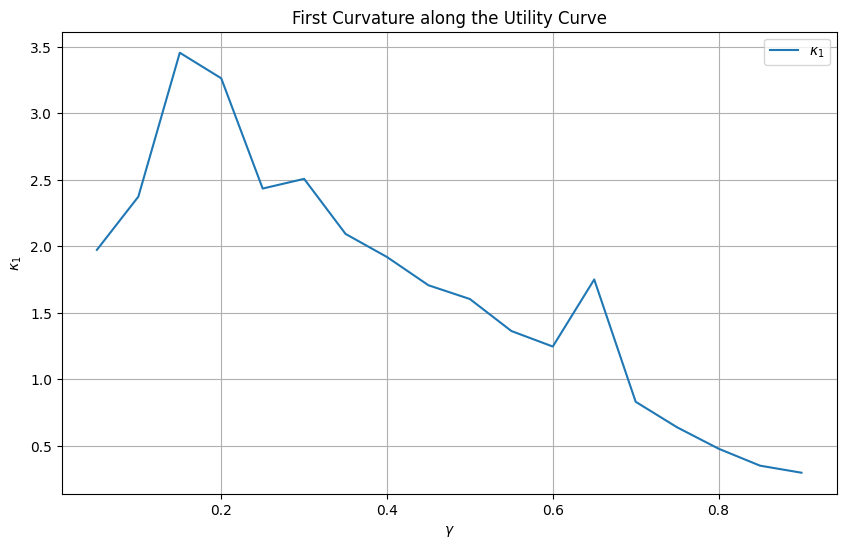

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you computed the utility matrix using gamma values stored in gamma_used.
# For example, if you computed for 20 equally spaced gamma values between 0 and 0.95:
N = 20  # adjust to your actual number of utility vectors
gamma_used = np.linspace(0, 0.95, N)  # gamma_used.shape = (N,)

# 'matrix' is assumed to be a NumPy array of shape (N, 9)
# For example, matrix = np.array([...]) obtained from your loop.

# Step 1. Compute differences between successive utility vectors.
diffs = np.diff(matrix, axis=0)  # shape: (N-1, 9)
ds = np.linalg.norm(diffs, axis=1)  # approximate arc length differentials, shape: (N-1,)

# Step 2. Compute cumulative arc length 's' along the curve.
s = np.concatenate(([0], np.cumsum(ds)))  # shape: (N,)

# Step 3. Compute the unit tangent vectors T at each segment.
T = diffs / ds[:, None]  # shape: (N-1, 9)

# Associate each tangent vector with an arc-length value (midpoint of s intervals).
s_T = (s[:-1] + s[1:]) / 2  # shape: (N-1,)

# Step 4. Approximate the derivative dT/ds using finite differences.
dT = np.diff(T, axis=0)         # shape: (N-2, 9)
ds_T = np.diff(s_T)             # shape: (N-2,)
kappa1 = np.linalg.norm(dT, axis=1) / ds_T  # curvature values, shape: (N-2,)

# For plotting, compute gamma values corresponding to these curvature estimates.
# First, get midpoints for the gamma values corresponding to T.
gamma_T = (gamma_used[:-1] + gamma_used[1:]) / 2  # shape: (N-1,)
# Then, average adjacent midpoints to associate with curvature (from differences of T).
gamma_curv = (gamma_T[:-1] + gamma_T[1:]) / 2  # shape: (N-2,)

# Plot the curvature κ₁ as a function of gamma.
plt.figure(figsize=(10, 6))
plt.plot(gamma_curv, kappa1, label=r'$\kappa_1$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\kappa_1$')
plt.title('First Curvature along the Utility Curve')
plt.legend()
plt.grid(True)
plt.show()
